In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, mean_squared_error, precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.datasets import load_boston
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pandas import Series
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
for dirname, _, filenames in os.walk('/home/stormrider/Desktop/Python/Credit_score'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/home/stormrider/Desktop/Python/Credit_score/test.csv
/home/stormrider/Desktop/Python/Credit_score/train.csv
/home/stormrider/Desktop/Python/Credit_score/credit_score_backup.ipynb
/home/stormrider/Desktop/Python/Credit_score/sample_submission.csv
/home/stormrider/Desktop/Python/Credit_score/.ipynb_checkpoints/credit_score_backup-checkpoint.ipynb


In [113]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [114]:
DATA_DIR = '/home/stormrider/Desktop/Python/Credit_score/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [115]:
def null_count(column):
    """Вывод информации о количестве пропущенных значений"""

    print(' Кол-во наблюдений:', column.isnull().count(), '\n',
          'Кол-во пропущенных значений:', column.isnull().sum(), '\n',
          'Процент пропущенных значений:',
          int(round(column.isnull().sum()/column.isnull().count()*100, 0)), '%', '\n',
          'Кол-во уникальных значений:', column.nunique())


def get_plot(column):
    """Вывод графика"""

    plt.figure(figsize=(14, 14))
    column.value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Number of observations')
    plt.show()


def to_numeric(data_f):
    """Преобразование признаков"""

    data_f = pd.get_dummies(data_f, columns=[
                            'home_address', 'work_address', 'sna', 'first_time'], dummy_na=False)
    data_f = pd.get_dummies(data_f, columns=['education'], dummy_na=True)
    data_f.sex = data_f.sex.apply(lambda x: 0 if x == 'F' else 1)
    for column in ['car', 'car_type', 'foreign_passport']:
        data_f[column] = data_f[column].apply(lambda x: 1 if x == 'Y' else 0)
    data_f.income = data_f.income.apply(lambda x: math.log(x))
    data_f['month'] = data.app_date.apply(lambda x: datetime.strptime(x,
                                                                      '%d%b%Y').month)
    # data_f['month']=data['month'].apply(lambda x: jun if x==1
    # else feb if x==2
    # else mar if x==3
    # else apr)
    data_f['day_of_week'] = data.app_date.apply(lambda x: datetime.strptime(x,
                                                                            '%d%b%Y').isoweekday())
    # data_f['day_of_week']=data['day_of_week'].apply(lambda x: sun if x==1
    # else mon if x==2
    # else tue if x==3
    # else wed if x==4
    # else thu if x==5
    # else fri if x==6
    # else sat)
    #max_date=data_f.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y')).max()
    #data_f.app_date=data.app_date.apply(lambda x: (max_date-datetime.strptime(x, '%d%b%Y')))
    data_f = data_f.drop(['client_id', 'app_date'],
                         axis='columns', inplace=False)
    data_f = pd.get_dummies(
        data_f, columns=['month', 'day_of_week'], dummy_na=False)
    return data_f

Тренировочный набор данных

In [116]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: float64(1), int64(12), object(6)
memory usage: 10.7+ MB


In [117]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Тестовый набор данных

In [118]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
client_id           36349 non-null int64
app_date            36349 non-null object
education           36178 non-null object
sex                 36349 non-null object
age                 36349 non-null int64
car                 36349 non-null object
car_type            36349 non-null object
decline_app_cnt     36349 non-null int64
good_work           36349 non-null int64
score_bki           36349 non-null float64
bki_request_cnt     36349 non-null int64
region_rating       36349 non-null int64
home_address        36349 non-null int64
work_address        36349 non-null int64
income              36349 non-null int64
sna                 36349 non-null int64
first_time          36349 non-null int64
foreign_passport    36349 non-null object
dtypes: float64(1), int64(11), object(6)
memory usage: 5.0+ MB


In [119]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Для корректной обработки признаков объединяем тренировочный и тестовый наборы данных в один датасет

In [120]:
df_train['sample'] = 1  # помечаем где у нас тренировочный датасет
df_test['sample'] = 0  # помечаем где у нас тестовый датасет
# В тестовом наборе данных нет значения Rating.
# Мы его должны предсказать, по этому пока просто заполняем нулями.
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

Подробнее по признакам:
* client_id: ID клиента в наборе данных
* app_date: Дата наблюдения
* education: Уровень образования
* sex: Пол заёмщика
* age: Возраст заемщика
* car: Флаг наличия автомобиля
* car_type: Флаг автомобиля-иномарки
* decline_app_cnt: Количество отказанных прошлых заявок
* good_work: Флаг наличия «хорошей» работы
* score_bki: Кредитный рейтинг
* bki_request_cnt: Количество запросов в БКИ
* region_rating: Рейтинг региона
* home_address: Категоризатор домашнего адреса
* work_address: Категоризатор рабочего адреса
* income: Доход заёмщика
* sna: Связь заемщика с клиентами банка
* first_time: Давность наличия информации о заемщике
* foreign_passport: Наличие загранпаспорта
* default: Наличие дефолта ( целевой параметр)

# 1 EDA

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
sample              110148 non-null int64
default             110148 non-null int64
dtypes: float64(1), int64(13), object(6)


Данные можно разделить на следующие категории:
1. Числовые признаки: app_date, age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income;
2. Категориальные признаки: client_id, education, sna, first_time, home_address, work_address;
3. Бинарные признаки: sex, age, car, car_type, good_work, foreign_passport, default.

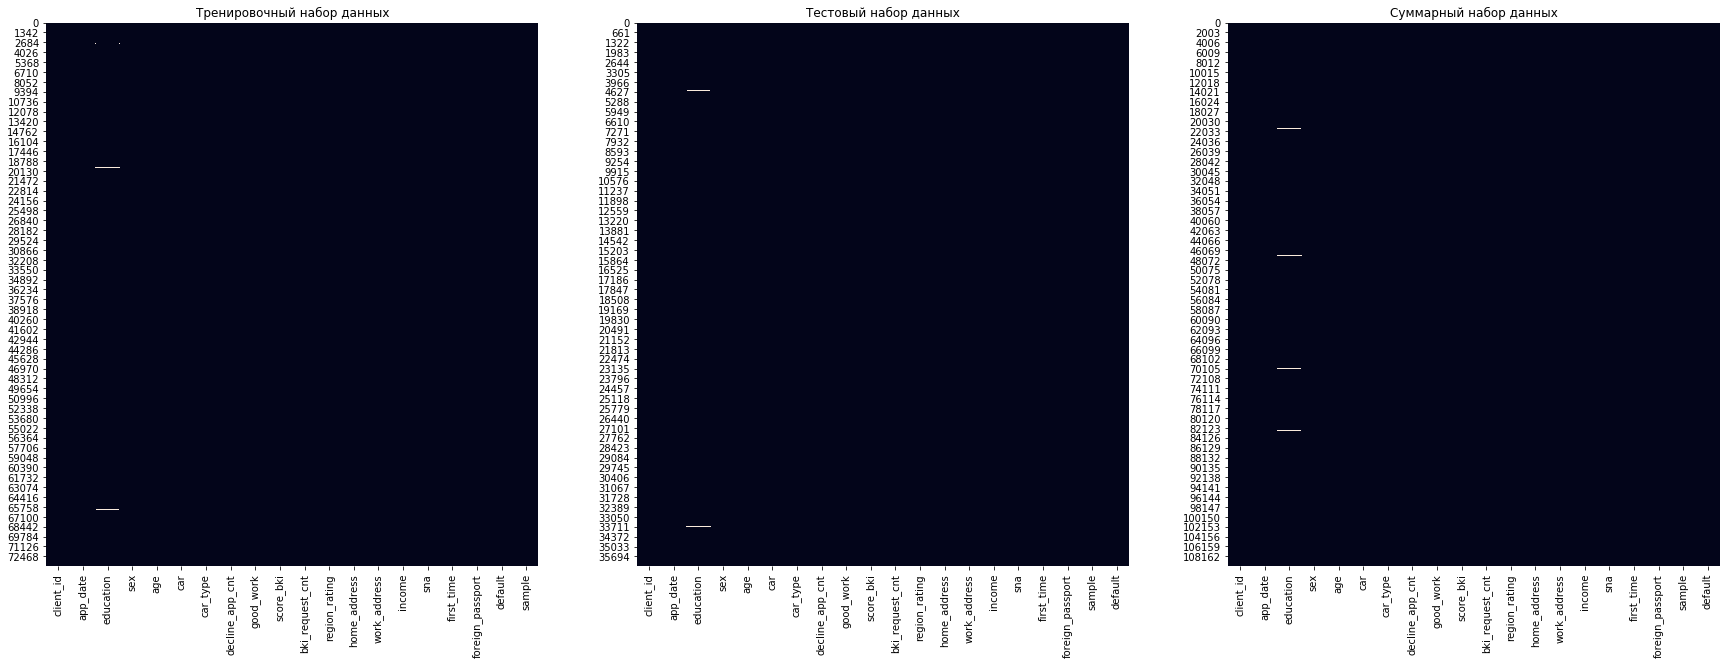

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.set_title('Тренировочный набор данных')
sns.heatmap(data=df_train.isnull(), cbar=False, ax=ax1)
ax2.set_title('Тестовый набор данных')
sns.heatmap(data=df_test.isnull(), cbar=False, ax=ax2)
ax3.set_title('Суммарный набор данных')
sns.heatmap(data=data.isnull(), cbar=False, ax=ax3)

Как видно из графиков, пропущенные значения тренировочного, тестового и, как следствие, суммарного наборов данных наблюдаются в одом параметре education.

## 1.1 client_id

In [123]:
null_count(data.client_id)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 110148


Данный параметр, характеризующий идентификатор заемщика, имеет количество значений, равное количеству наблюдений. Из этого можно сделать вывод, что данный параметр не поможет обучить модель, его можно исключить перед обучением модели.

## 1.2 app_date

In [124]:
null_count(data.app_date)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 120


Данный параметр характеризует дату наблюдения. Данный параметр будет удобно анализировать, преобразовав в числовой формат.

Посмотрим на год, в котором было проведено наблюдение:

In [125]:
data.app_date.apply(lambda x: re.findall(r'\d\d\d\d', x)[0]).unique()

array(['2014'], dtype=object)

Как видно, все наблюдения были проведены в 2014 году. Информацию о годе наблюдения можно исключить из набора данных перед обучением модели.

Проверим корректность введения месяца и дня даты наблюдения.

In [126]:
data.app_date.apply(lambda x: x[2:5]).value_counts()

MAR    31597
FEB    27097
APR    26266
JAN    25188
Name: app_date, dtype: int64

Названия месяцев введены правильно: Январь, Февраль, Март и Апрель.

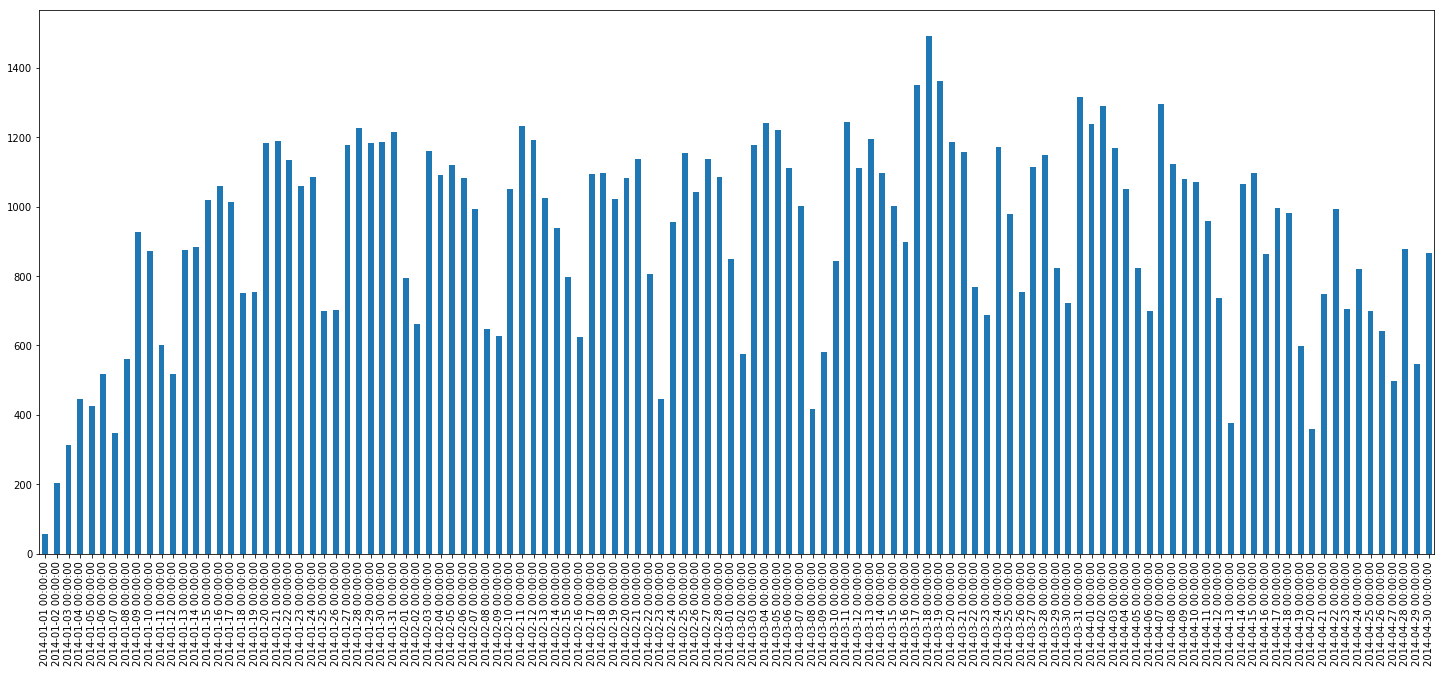

In [127]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y')).value_counts().sort_index().plot.bar()

На первый взгляд, наибольшее количество наблюдений произошло в марте. Посмотрим подробнее.

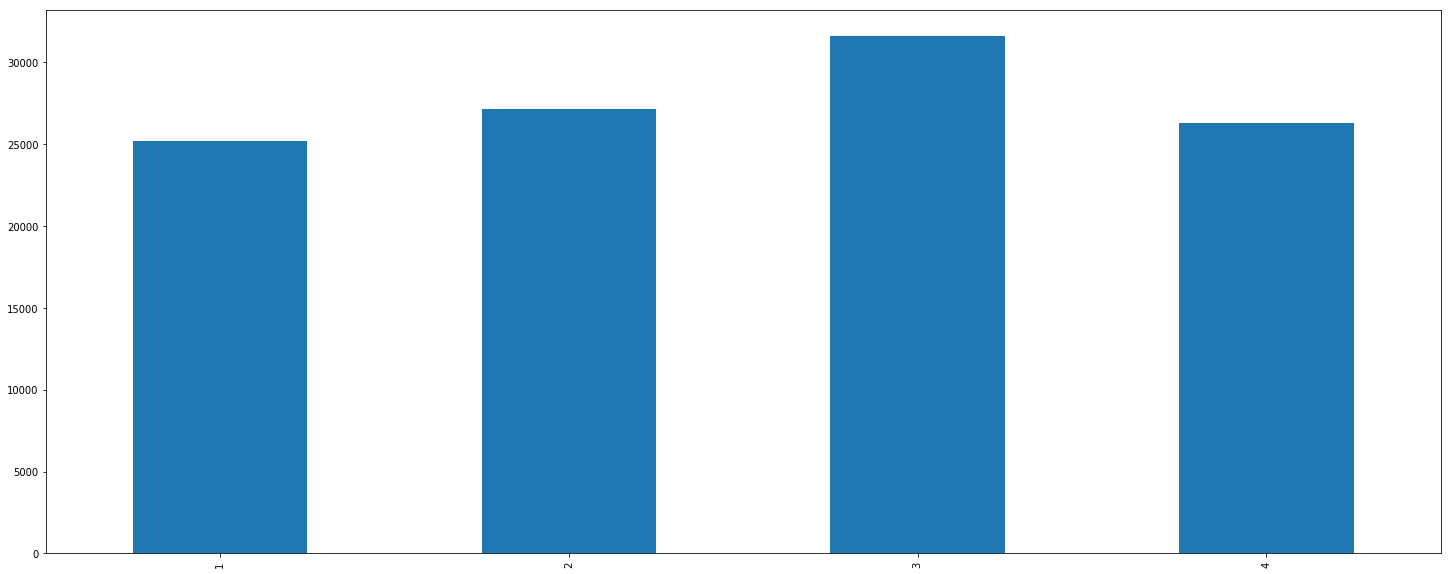

In [128]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y').month).value_counts().sort_index().plot.bar()

Действительно, большинство запросов произошло в марте, при этом незначительно отличаясь от запросов, произошедших в течение других месяцев. Посмотрим на распределения количества запросов по дням недели.

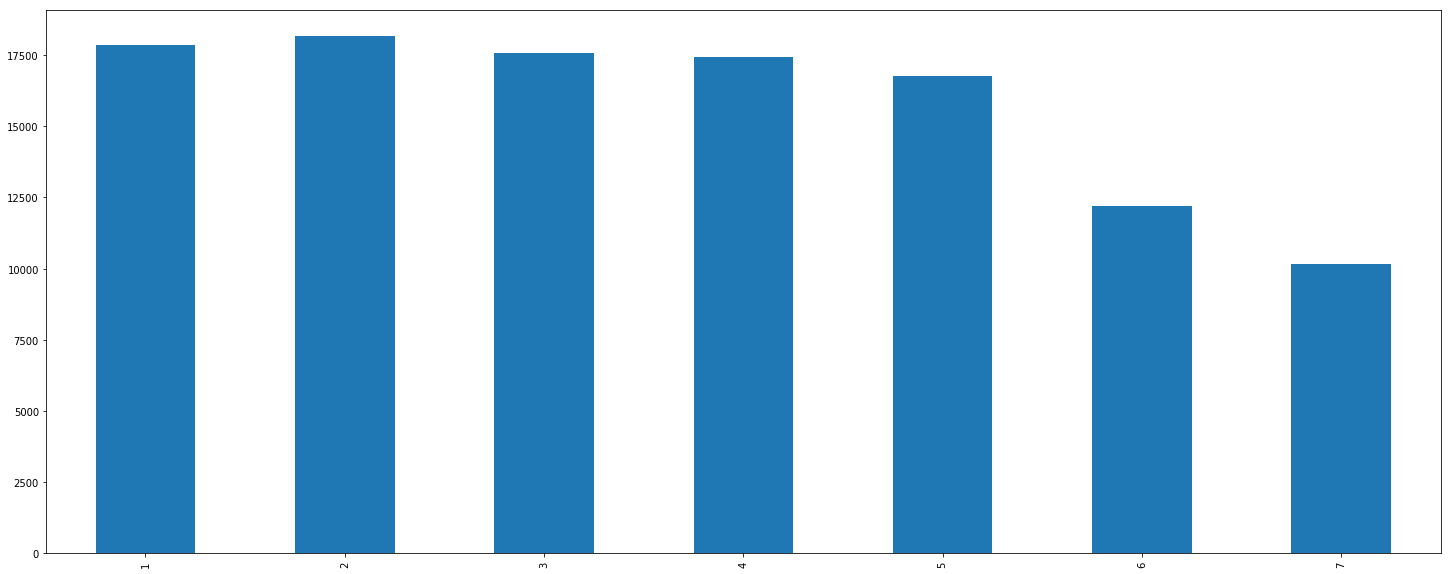

In [129]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y').isoweekday()).value_counts().sort_index().plot.bar()

Наименьшее количество запросов произошло пятницу и субботу. Максимальное - в воскресенье и понедельник. В целом, количество запросов в будние дни разбросано незначительно.

##### В дальнейшем выведем следующие параметры: месяцы, дни недели в качестве бинарных признаков и количество дней между самым ранним наблюдением и актуальным наблюдением в качестве числового признака.

## 1.3 education

In [130]:
null_count(data.education)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 478 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 5


Количество пропущенных значений очень мало. Посмотрим на них подробнее.

In [131]:
for column in data.columns.tolist():
    if column != 'education':
        print(column, data[pd.isnull(data.education)
                           == True][column].nunique())
    else:
        continue

client_id 478
app_date 113
sex 2
age 50
car 2
car_type 2
decline_app_cnt 4
good_work 2
score_bki 474
bki_request_cnt 15
region_rating 6
home_address 3
work_address 3
income 77
sna 4
first_time 4
foreign_passport 2
sample 2
default 2


Никаких интересных закономерностей касательно влияния других признаков на исследуемый параметр не замечено.

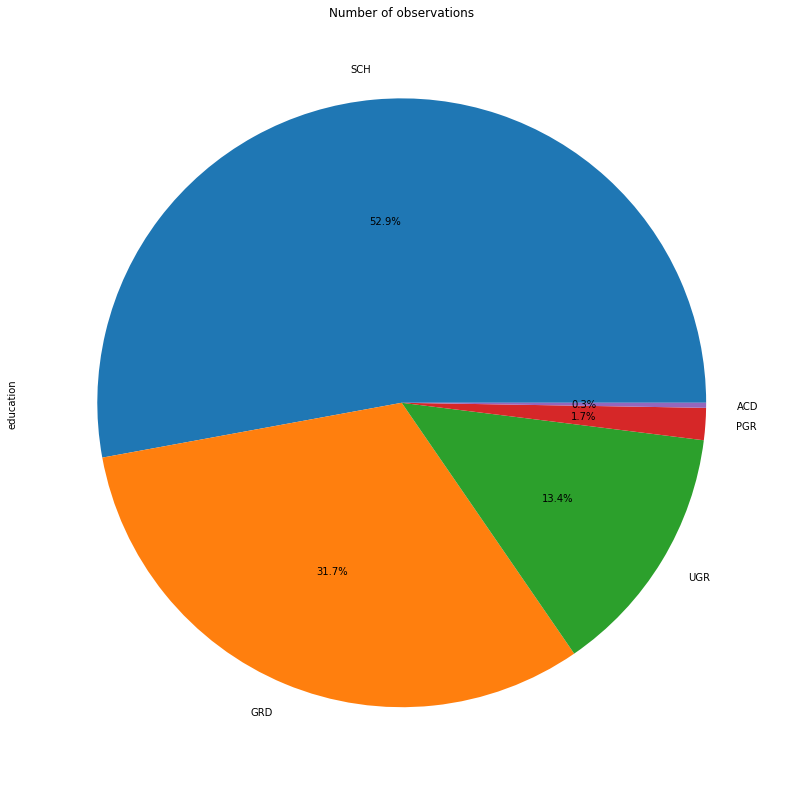

In [132]:
get_plot(data.education)

Видно, что количество наблюдений уменьшается с увеличением уровня образования. Более 50% процентов заемщиков не имеют высшего образования, около 45% являются бакалаврами или кандидатами в бакалавры. Только 2,1% процентов заемщиков являются магистрами и академиками.

Планируется вывести бинарные признаки по значениям данного признака.

## 1.4 sex

In [133]:
null_count(data.sex)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


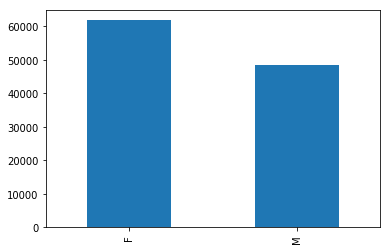

In [134]:
data.sex.value_counts().plot.bar()

Среди заемщиков больше женщин. Перед обучением модели стоит привести данный признак к числовом виду.

## 1.5 age

In [135]:
null_count(data.age)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 52


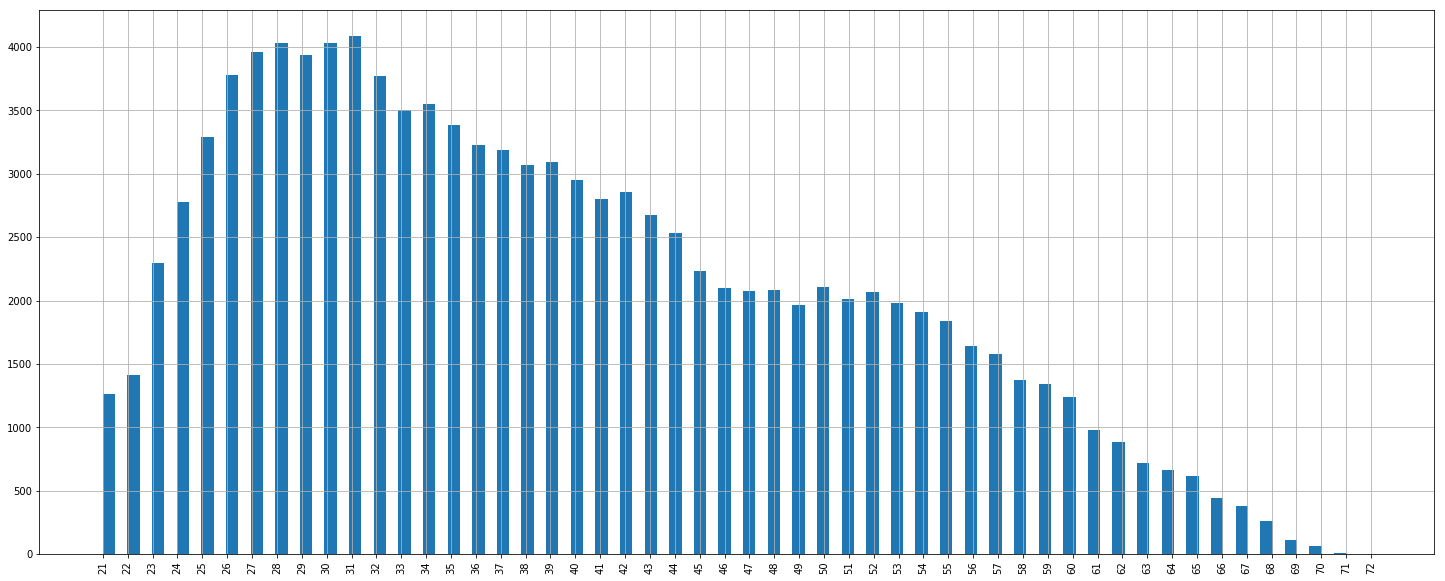

In [136]:
plt.figure(figsize=(25, 10))
plt.xticks(rotation=90, ticks=data.age.unique())
data.age.hist(bins=103)

Как видно, количество заемщиков резко растет до 30-31 лет, далее оно плавно уменьшается с возрастом.

## 1.6 car

In [137]:
null_count(data.car)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


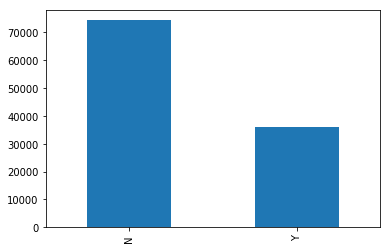

In [138]:
data.car.value_counts().plot.bar()

Большинство заемщиков не имеют автомобилей.

## 1.7 car_type

In [139]:
null_count(data.car_type)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


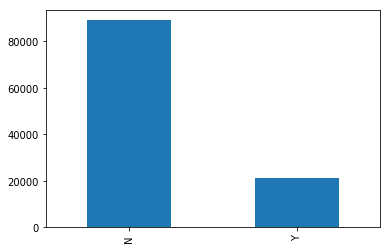

In [140]:
data.car_type.value_counts().plot.bar()

Большинство заемщиков не имеют иностранных автомобилей.

In [141]:
data[data.car_type == 'Y'].car.unique()

array(['Y'], dtype=object)

Как видно, логических ошибок в вводе данных в признаках car и car_type нет.

## 1.8 decline_app_cnt

In [142]:
null_count(data.decline_app_cnt)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 24


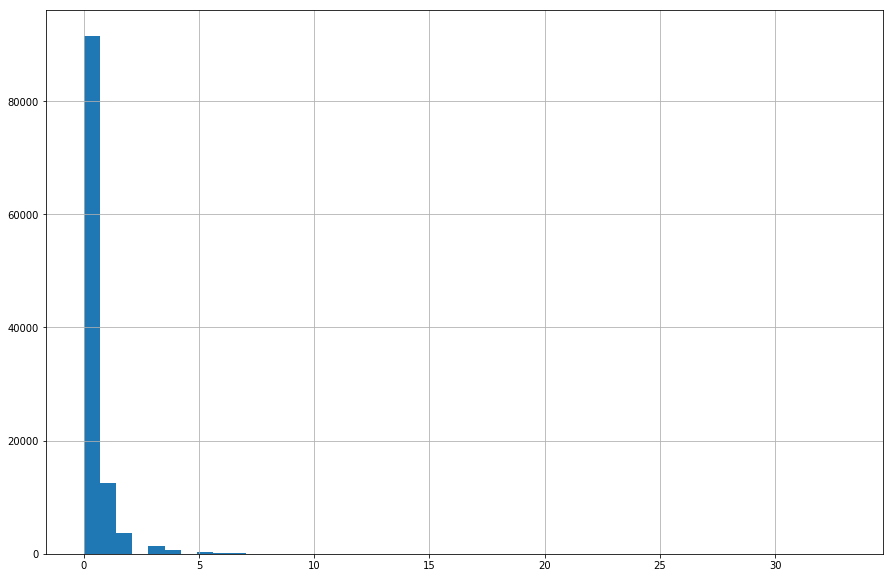

In [143]:
plt.figure(figsize=(15, 10))
data.decline_app_cnt.hist(bins=47)

Большинство заемщиков из выборки не имеют отклоненных заявок. Небольшое количество имеют 1-2 отклоненные заявки. Количество заемщиков с количеством отклоненных заявок не менее 2 очень мало. Основываясь на данном параметре можно выделить следующий бинарный признак: наличие отклоненных заявок.

## 1.9 good_work

In [144]:
null_count(data.good_work)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


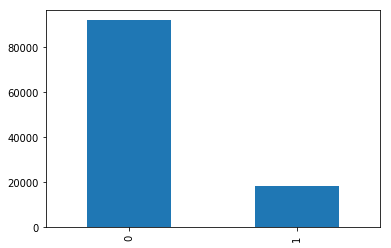

In [145]:
data.good_work.value_counts().plot.bar()

Подавляющее количество наблюдений фиксируют отсутствие "хорошей" работы у заемщиков. Данный признак числовой, не нуждается в предварительной обработке.

## 1.10 score_bki

In [146]:
null_count(data.score_bki)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 102618


Количество уникальных значений параметра практически равно количеству наблюдений.

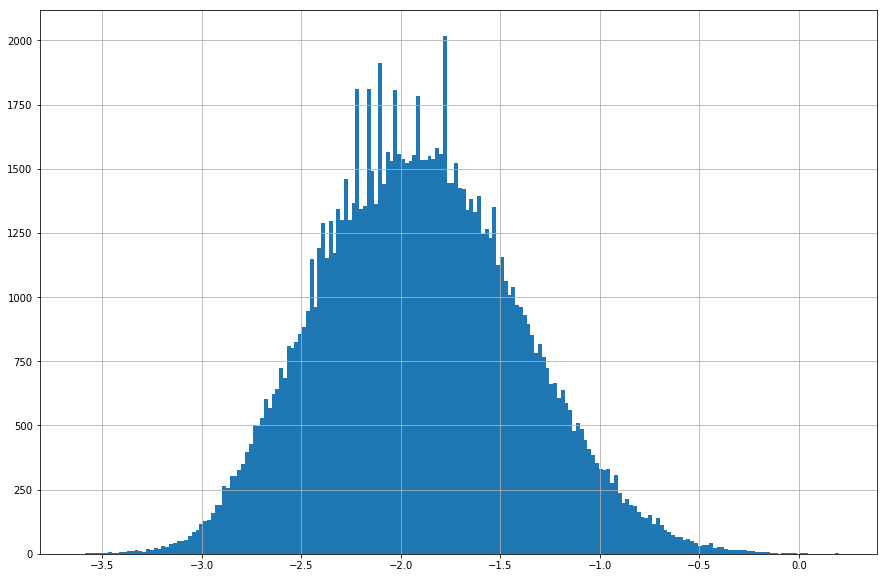

In [147]:
plt.figure(figsize=(15, 10))
data.score_bki.hist(bins=200)

Видно, что признак распределен нормально. Большинство заемщиков имеют "средний" рейтинг. При этом количество заемщиков при отклонении их рейтинга от "среднего" значения резко уменьшается.

## 1.11 bki_request_cnt

In [148]:
null_count(data.bki_request_cnt)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 40


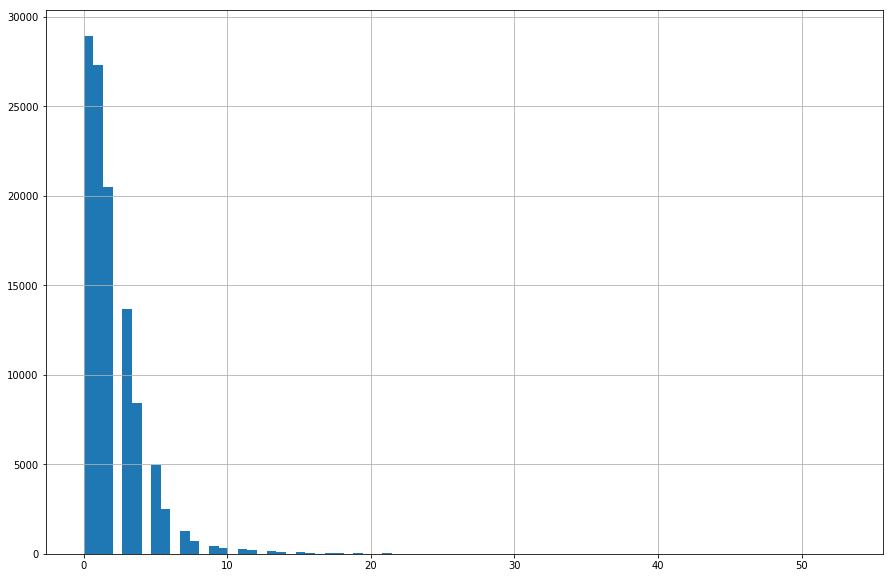

In [149]:
plt.figure(figsize=(15, 10))
data.bki_request_cnt.hist(bins=79)

Большинство наблюдений имеют от 0 до 2 запросов в БКИ. Можно выедлить бинарный признак: отсутствие более двух запросов.

## 1.12 region_rating

In [150]:
null_count(data.region_rating)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 7


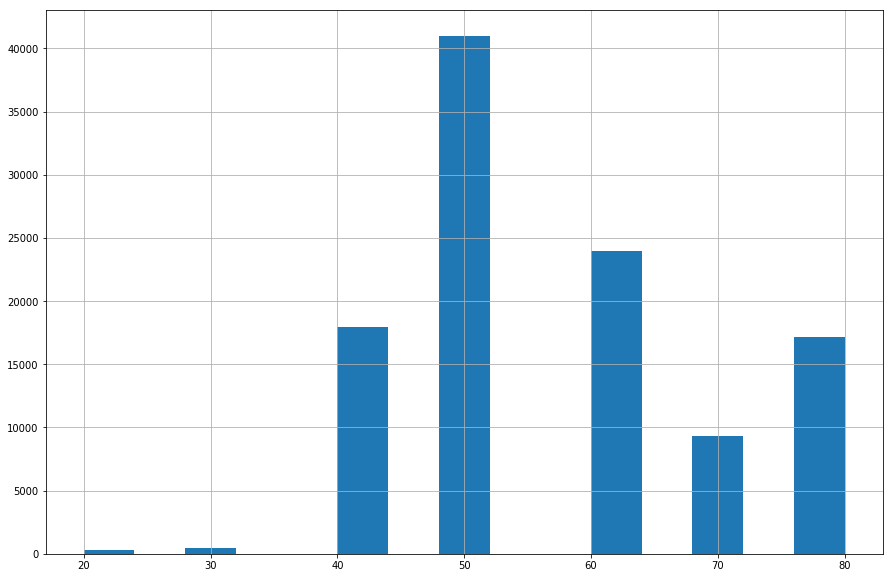

In [151]:
plt.figure(figsize=(15, 10))
data.region_rating.hist(bins=15)

Видно, что признак распределен нормально. Большинство наблюдений имеют "средний" рейтинг региона. При этом количество наблюдений при отклонении рейтинга региона от "среднего" значения уменьшается: резко слева и плавно справа.

## 1.13 home_address

In [152]:
null_count(data.home_address)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 3


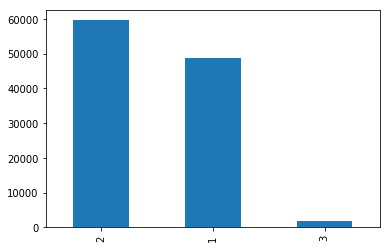

In [153]:
data.home_address.value_counts().plot.bar()

Большинство наблюдений имеют 2 и 1 категории домашнего адреса. В дальнейшем стоит вывести бинарные признаки по данным категориям.

## 1.14 work_address

In [154]:
null_count(data.work_address)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 3


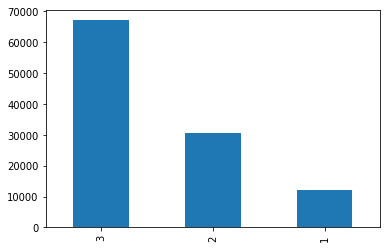

In [155]:
data.work_address.value_counts().plot.bar()

Количество наблюдений резко увеличивается при увеличении категории места работы. Далее Выведем бинарные признаки по данным категориям.

## 1.15 income

In [156]:
null_count(data.income)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 1207


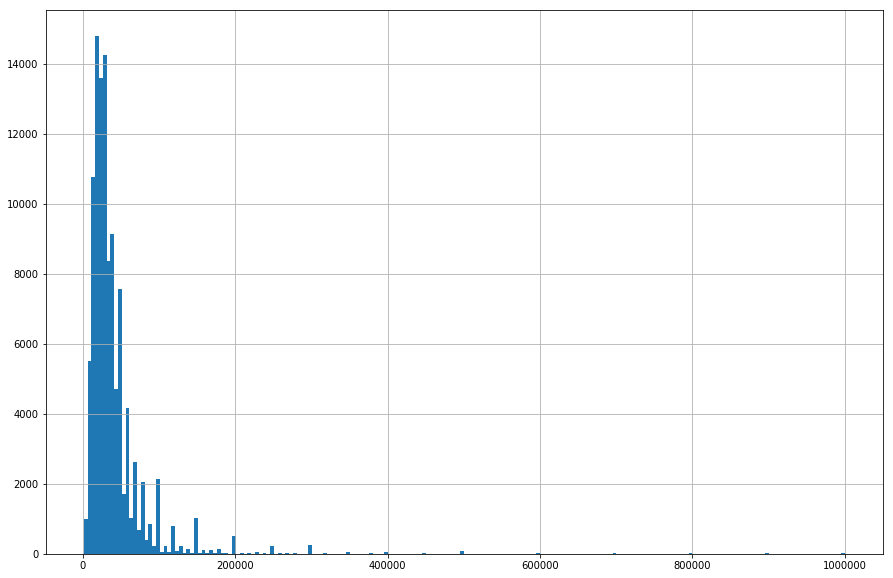

In [157]:
plt.figure(figsize=(15, 10))
data.income.hist(bins=200)

Данный признак имеет "хвост" справа. Попробуем нормализовать данный параметр путем логарифмирования.

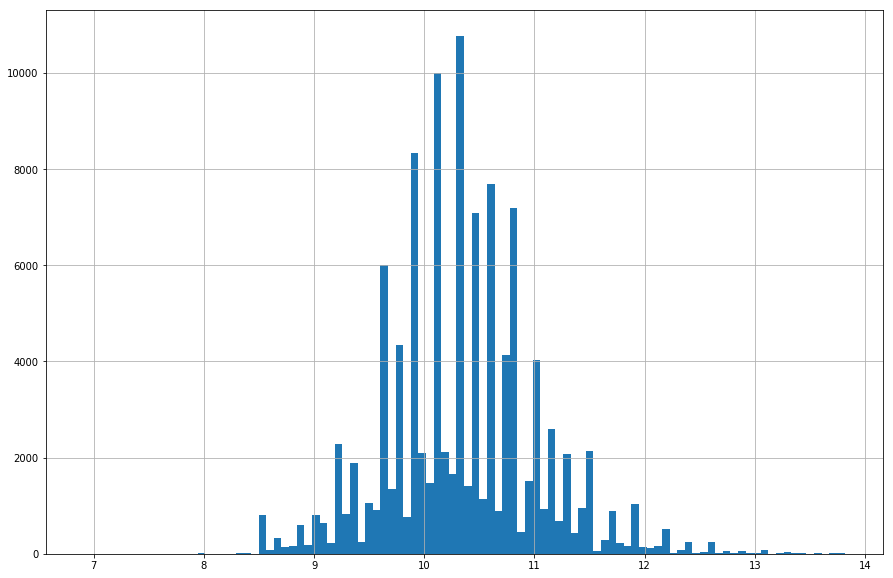

In [158]:
plt.figure(figsize=(15, 10))
data.income.apply(lambda x: math.log(x)).hist(bins=100)

После логарифмирования признак имеет нормальное распределение. В дальнейшем стоит провести операцию логарифмирования.

## 1.16 sna

In [159]:
null_count(data.sna)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 4


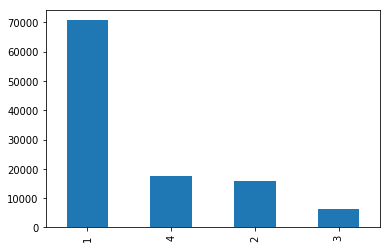

In [160]:
data.sna.value_counts().plot.bar()

Большинство наблюдений имеют значение параметра 1. В дальнейшем выведем бинарные признаки по данным категориям.

## 1.17 first_time

In [161]:
null_count(data.first_time)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 4


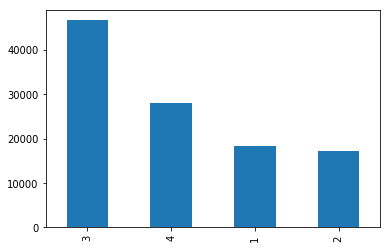

In [162]:
data.first_time.value_counts().plot.bar()

Большинство наблюдений имеют значение параметра 3. Количество значений 1, 2, 4 в среднем составляют половину от количества значений 3. Далее добавим бинарные признаки по данным значениям в набор данных.

## 1.18 foreign_passport

In [163]:
null_count(data.foreign_passport)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


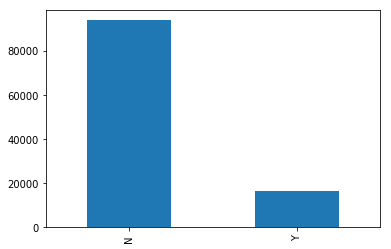

In [164]:
data.foreign_passport.value_counts().plot.bar()

Большинство заемщиков не имеют загранпаспорта. Далее стоит привести данный признак к числовому виду.

## 1.19 default ( целевой параметр)

In [165]:
null_count(data.default)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


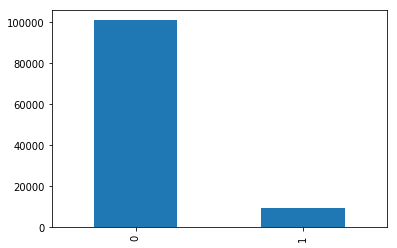

In [166]:
data.default.value_counts().plot.bar()

Подавляющее количество заемщиков не имеют дефолта по кредиту.

## 1.20 Корреляция признаков

In [167]:
def cramers_V(var1, var2):
    """Метод крамера"""

    # Построение таблицы сопряженности для двух параметров
    confusion_matrix = np.array(pd.crosstab(
        var1, var2, rownames=None, colnames=None))
    # Получение расчитанной статистики. Нам нужен только первый возвращаемый аргумент
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

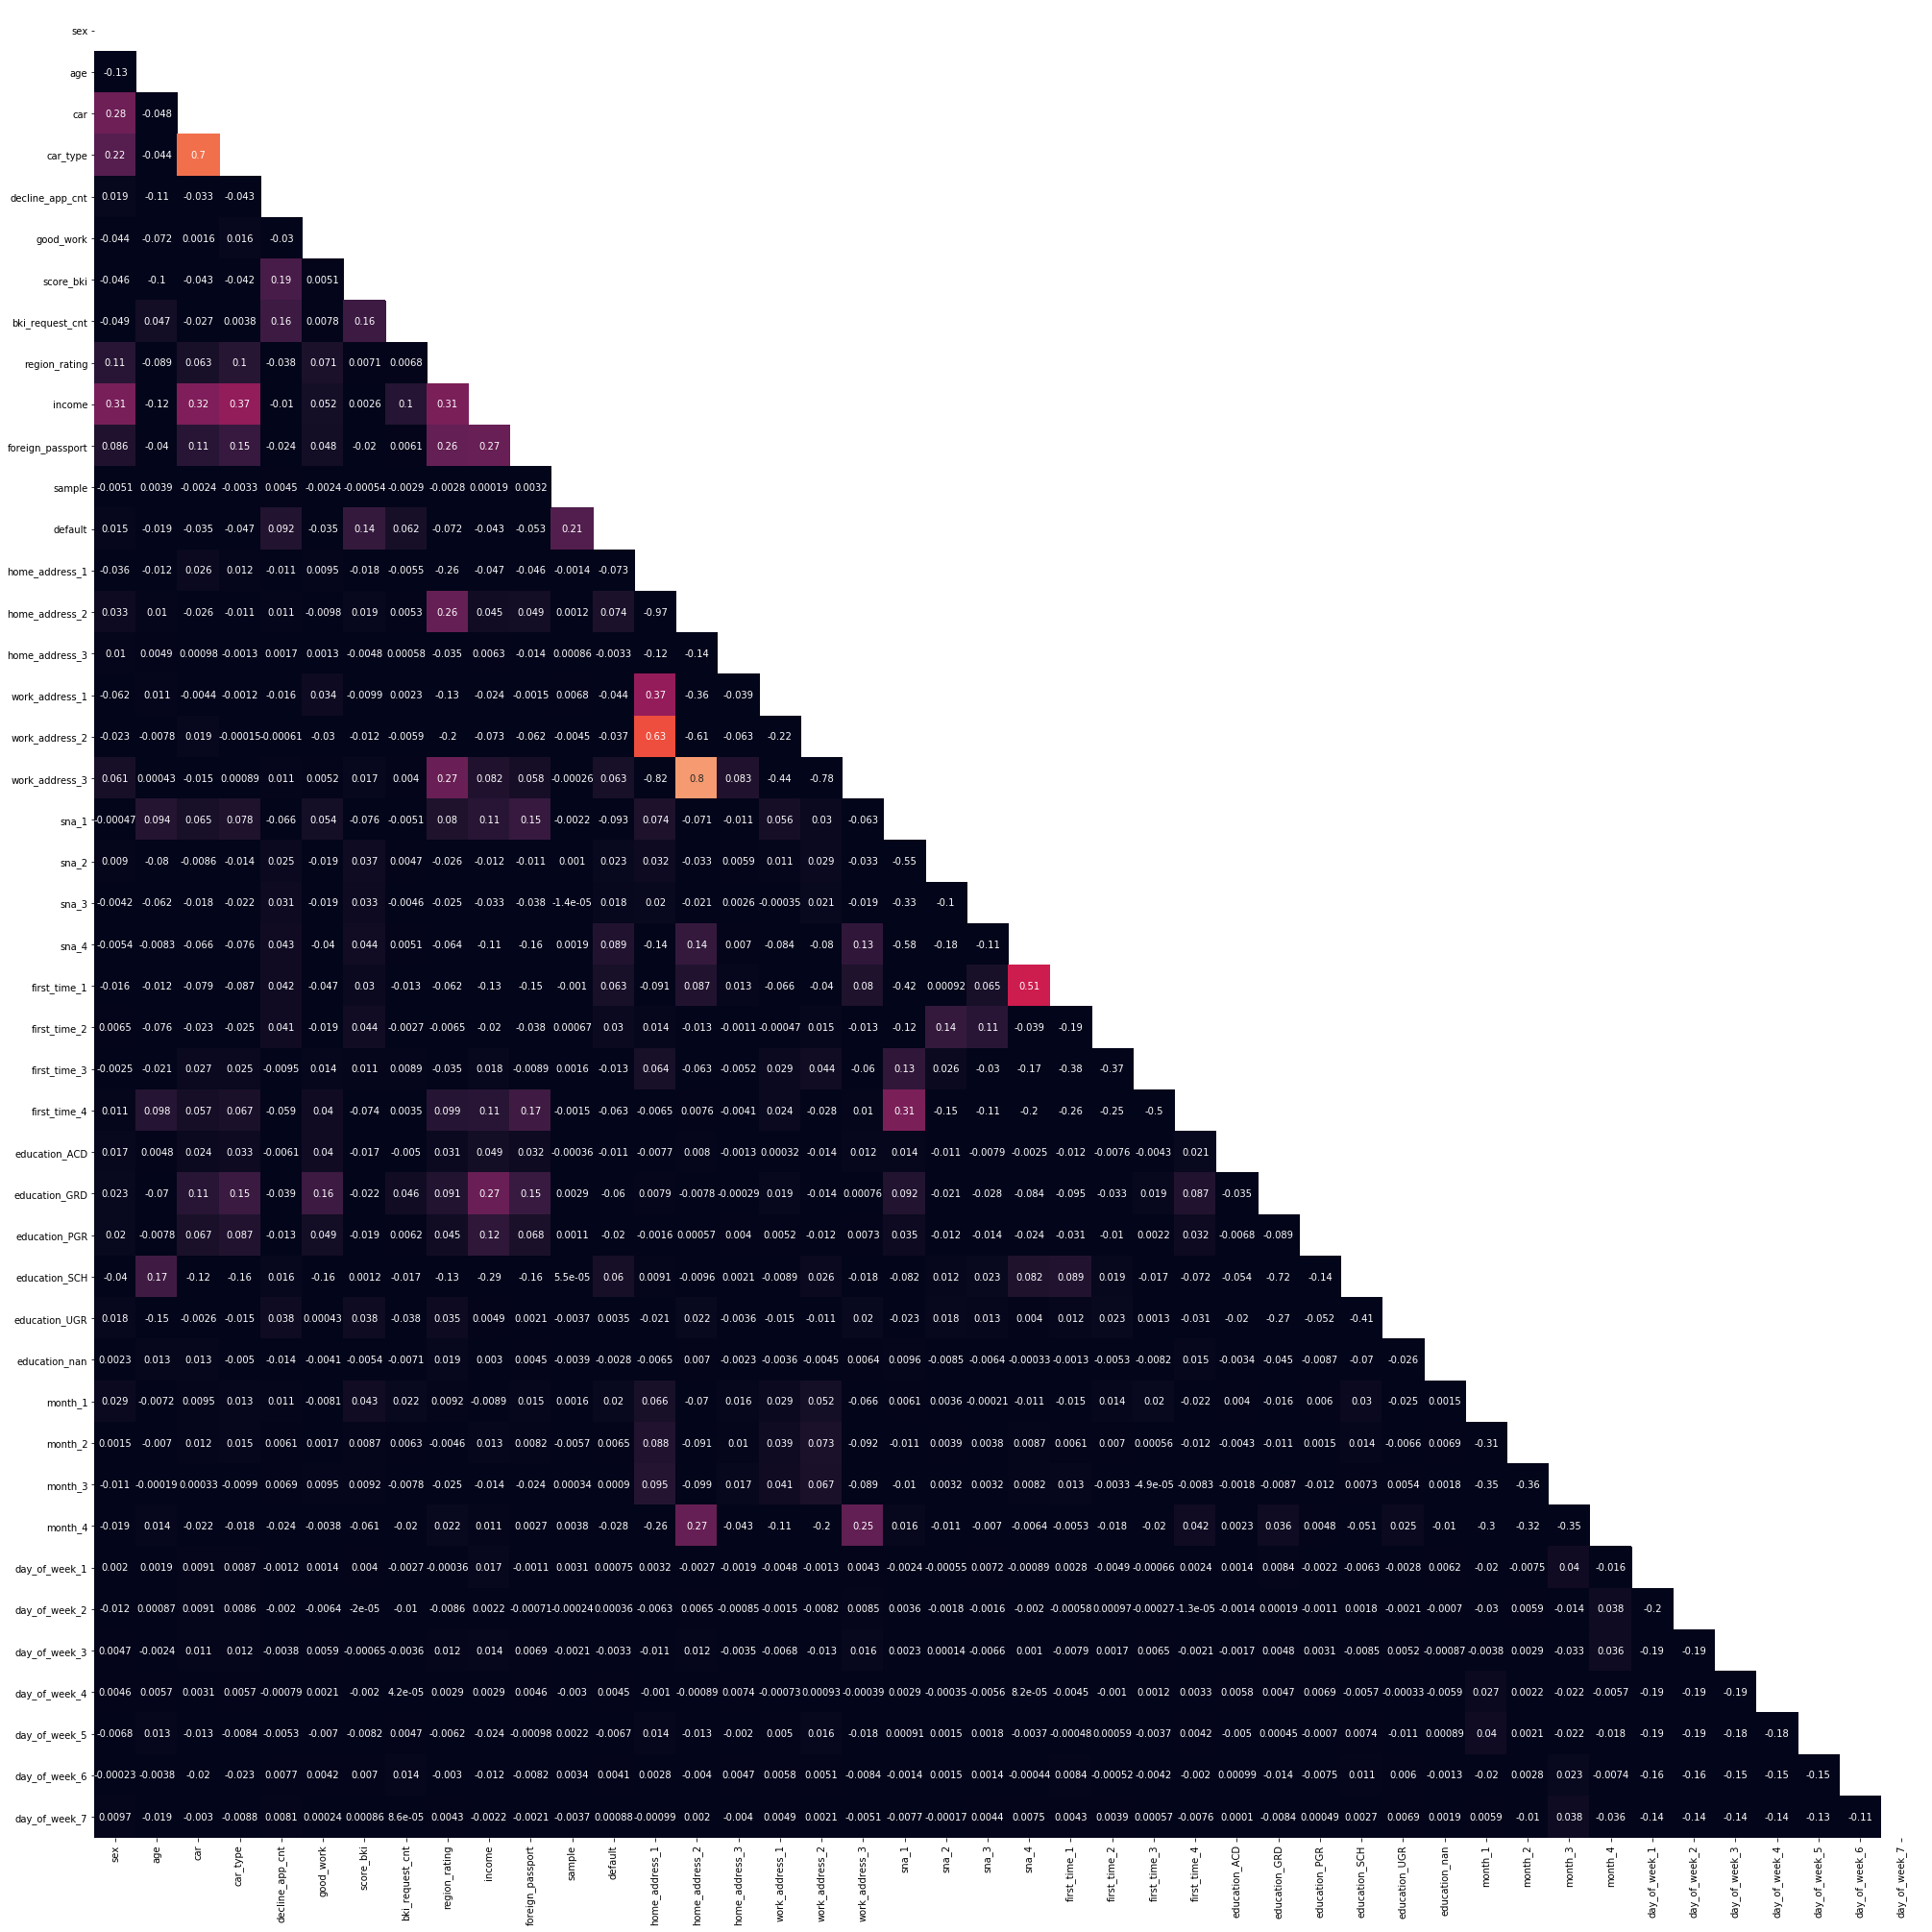

In [168]:
mask = np.zeros_like(to_numeric(data).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(35, 35))
with sns.axes_style("white"):
    ax = sns.heatmap(to_numeric(data).corr(), mask=mask, vmin=0.,
                     vmax=1, square=True, annot=True, cbar=False)

plt.show()

##### Как видно, между собой сильно коррелируют признаки car и car_type, sna_4 и first_time_1, work_address_3 и home_address_2

# 2 Feature Engineering

##### По результатам разведочного анализа данных проведем следующие преобразования в наборе данных:
* Удалим client_id;
* Преобразуем бинарные признаки sex, car, car_type, foreign_passport в числовой формат;
* Преобразуем значения категориальных признаков home_address, work_address, sna, first_time, education в бинарные признаки;
* Преобразуем признак app_date в бинарные признаки месяцев и дней недели;
* Логарифмируем признак income.

In [169]:
data_k=to_numeric(data)

## 2.1 Значимость числовых признаков на целевой параметр

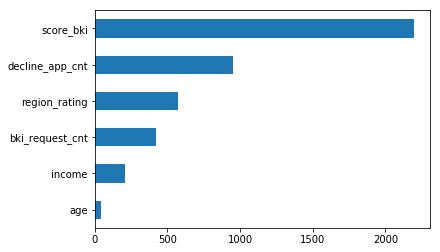

In [170]:
imp_num = Series(f_classif(data_k[[
    'age', 'decline_app_cnt',
    'score_bki', 'bki_request_cnt',
    'region_rating', 'income']], data_k['default'])[0],
    index=['age', 'decline_app_cnt',
           'score_bki', 'bki_request_cnt',
           'region_rating', 'income'])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Самым значимым числовым параметром является кредитный рейтинг. Наименее значимым - возраст заемщика.

## 2.2 Значимость бинарных признаков на целевой параметр

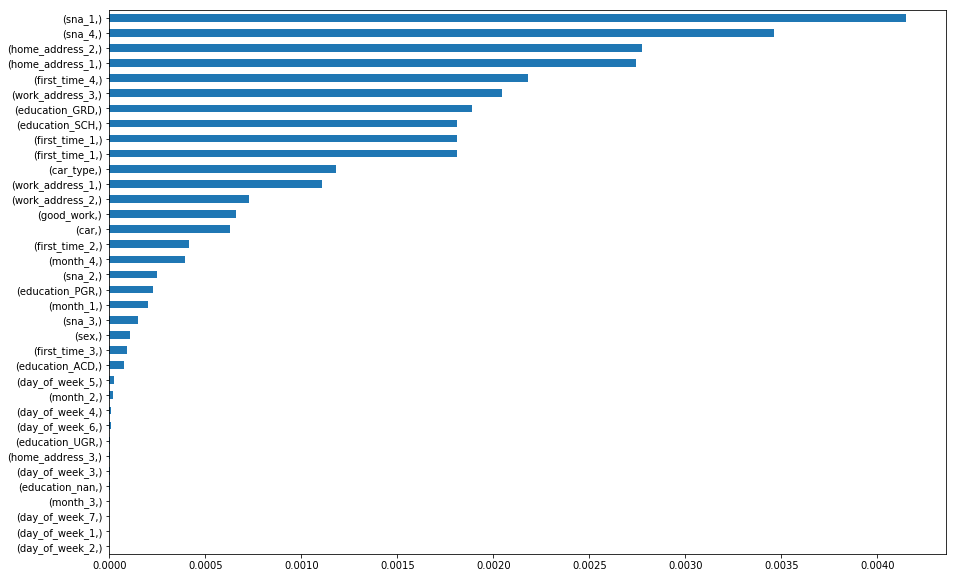

In [171]:
imp_cat = Series(mutual_info_classif(data_k[[
    'sex', 'car', 'car_type', 'good_work', 'home_address_1',
    'home_address_2', 'home_address_3', 'work_address_1',
    'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3',
    'sna_4', 'first_time_1', 'first_time_1', 'first_time_2',
    'first_time_3', 'first_time_4', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH',
    'education_UGR', 'education_nan', 'month_1', 'month_2',
    'month_3', 'month_4', 'day_of_week_1', 'day_of_week_2',
    'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
    'day_of_week_6', 'day_of_week_7']], data_k['default'], discrete_features=True),
    index=[['sex', 'car', 'car_type', 'good_work', 'home_address_1',
            'home_address_2', 'home_address_3', 'work_address_1',
            'work_address_2', 'work_address_3', 'sna_1', 'sna_2',
            'sna_3', 'sna_4', 'first_time_1', 'first_time_1',
            'first_time_2', 'first_time_3', 'first_time_4',
            'education_ACD', 'education_GRD', 'education_PGR',
            'education_SCH', 'education_UGR', 'education_nan',
            'month_1', 'month_2', 'month_3', 'month_4',
            'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
            'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
            'day_of_week_7']])
imp_cat.sort_values(inplace=True)
plt.figure(figsize=(15, 10))
imp_cat.plot(kind='barh')

Наименьшая значимость наблюдается у признаков: day_of_week_1, day_of_week_2, day_of_week_3, day_of_week_4, day_od_week_6, day_of_week_7, month_3, education_nan, home_address_3, education_UGR.

# 3 ML

Выделим тестовую часть

In [172]:
train_data = data_k.query('sample == 1').drop(['sample'], axis=1)
test_data = data_k.query('sample == 0').drop(['sample'], axis=1)

Стандартизируем числовые признаки

In [173]:
X_num = StandardScaler().fit_transform(train_data[[
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
    'region_rating', 'income']].values)

Объединим стандартизованные числовые и бинарные признаки в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [174]:
X_bin_cat = train_data[[
    'sex', 'car', 'car_type', 'good_work', 'home_address_1',
    'home_address_2', 'home_address_3', 'work_address_1',
    'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3',
    'sna_4', 'first_time_1', 'first_time_1', 'first_time_2',
    'first_time_3', 'first_time_4', 'education_ACD', 'education_GRD',
    'education_PGR', 'education_SCH', 'education_UGR', 'education_nan',
    'month_1', 'month_2', 'month_3', 'month_4', 'day_of_week_1',
    'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
    'day_of_week_6', 'day_of_week_7']].values

In [175]:
X = np.hstack([X_num, X_bin_cat])
Y = train_data['default'].values

Разобьем набор данных на обучающую и тестовую выборки, предварительно стандартизировав числовые признаки.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Обучим модель.

In [177]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Оценим качество модели.

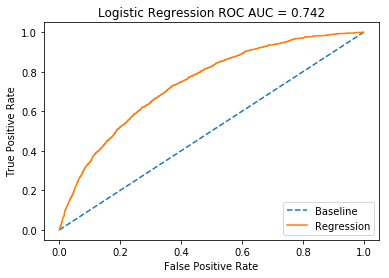

In [178]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Поиск гиперпараметров.

In [185]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l1, score=0.8715277777777778, total=   6.0s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l1, score=0.8726287262872628, total=   5.7s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l1, score=0.8719512195121951, total=   4.3s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=1.0, penalty=l1, score=0.871019647696477, total=  10.2s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.2s remaining:    0.0s
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l1, score=0.8713475057169475, total=   7.4s
[CV] C=1.0, penalty=l2 ...............................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=1.0, penalty=l2 ...............................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l2, score=0.8726287262872628, total=   0.4s
[CV] C=1.0, penalty=l2 ...............................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l2, score=0.8719512195121951, total=   0.4s
[CV] C=1.0, penalty=l2 ...............................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=1.0, penalty=l2 ...............................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=1.0, penalty=l2, score=0.8713475057169475, total=   0.3s
[CV] C=2.7825594022071245, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l1, score=0.8715277777777778, total=   9.8s
[CV] C=2.7825594022071245, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l1, score=0.8726287262872628, total=   8.6s
[CV] C=2.7825594022071245, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l1, score=0.8719512195121951, total=   8.3s
[CV] C=2.7825594022071245, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l1, score=0.8709349593495935, total=   2.2s
[CV] C=2.7825594022071245, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l1, score=0.8713475057169475, total=   7.9s
[CV] C=2.7825594022071245, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=2.7825594022071245, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=2.7825594022071245, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l2, score=0.8720359078590786, total=   0.3s
[CV] C=2.7825594022071245, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=2.7825594022071245, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=2.7825594022071245, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=7.742636826811269, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l1, score=0.8715277777777778, total=   1.6s
[CV] C=7.742636826811269, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l1, score=0.8726287262872628, total=   1.7s
[CV] C=7.742636826811269, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l1, score=0.8720359078590786, total=   3.5s
[CV] C=7.742636826811269, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l1, score=0.8709349593495935, total=   3.1s
[CV] C=7.742636826811269, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l1, score=0.8711781146777335, total=   2.6s
[CV] C=7.742636826811269, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=7.742636826811269, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=7.742636826811269, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l2, score=0.8720359078590786, total=   0.3s
[CV] C=7.742636826811269, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=7.742636826811269, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=7.742636826811269, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=21.544346900318832, penalty=l1 ................................
[CV]  C=21.544346900318832, penalty=l1, score=0.8715277777777778, total=   0.1s
[CV] C=21.544346900318832, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l1, score=0.8726287262872628, total=   0.2s
[CV] C=21.544346900318832, penalty=l1 ................................
[CV]  C=21.544346900318832, penalty=l1, score=0.8720359078590786, total=   0.2s
[CV] C=21.544346900318832, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l1, score=0.8709349593495935, total=   0.2s
[CV] C=21.544346900318832, penalty=l1 ................................
[CV]  C=21.544346900318832, penalty=l1, score=0.8711781146777335, total=   0.2s
[CV] C=21.544346900318832, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=21.544346900318832, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=21.544346900318832, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=21.544346900318832, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=21.544346900318832, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=21.544346900318832, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=59.94842503189409, penalty=l1 .................................
[CV]  C=59.94842503189409, penalty=l1, score=0.8715277777777778, total=   0.2s
[CV] C=59.94842503189409, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l1, score=0.8726287262872628, total=   0.1s
[CV] C=59.94842503189409, penalty=l1 .................................
[CV]  C=59.94842503189409, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=59.94842503189409, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l1, score=0.8709349593495935, total=   0.1s
[CV] C=59.94842503189409, penalty=l1 .................................
[CV]  C=59.94842503189409, penalty=l1, score=0.8711781146777335, total=   0.1s
[CV] C=59.94842503189409, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=59.94842503189409, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=59.94842503189409, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=59.94842503189409, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=59.94842503189409, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=59.94842503189409, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV]  C=166.81005372000593, penalty=l1, score=0.8715277777777778, total=   0.1s
[CV] C=166.81005372000593, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l1, score=0.8726287262872628, total=   0.1s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV]  C=166.81005372000593, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=166.81005372000593, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l1, score=0.8709349593495935, total=   0.2s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV]  C=166.81005372000593, penalty=l1, score=0.8711781146777335, total=   0.1s
[CV] C=166.81005372000593, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=166.81005372000593, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=166.81005372000593, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=166.81005372000593, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=166.81005372000593, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=166.81005372000593, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV]  C=464.15888336127773, penalty=l1, score=0.8715277777777778, total=   0.2s
[CV] C=464.15888336127773, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l1, score=0.8726287262872628, total=   0.2s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV]  C=464.15888336127773, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=464.15888336127773, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l1, score=0.8709349593495935, total=   0.2s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV]  C=464.15888336127773, penalty=l1, score=0.8711781146777335, total=   0.2s
[CV] C=464.15888336127773, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=464.15888336127773, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=464.15888336127773, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=464.15888336127773, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=464.15888336127773, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=464.15888336127773, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV]  C=1291.5496650148827, penalty=l1, score=0.8715277777777778, total=   0.1s
[CV] C=1291.5496650148827, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l1, score=0.8726287262872628, total=   0.1s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV]  C=1291.5496650148827, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=1291.5496650148827, penalty=l1 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l1, score=0.8709349593495935, total=   0.1s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV]  C=1291.5496650148827, penalty=l1, score=0.8711781146777335, total=   0.2s
[CV] C=1291.5496650148827, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=1291.5496650148827, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=1291.5496650148827, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=1291.5496650148827, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=1291.5496650148827, penalty=l2 ................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=1291.5496650148827, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=3593.813663804626, penalty=l1 .................................
[CV]  C=3593.813663804626, penalty=l1, score=0.8715277777777778, total=   0.1s
[CV] C=3593.813663804626, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l1, score=0.8726287262872628, total=   0.2s
[CV] C=3593.813663804626, penalty=l1 .................................
[CV]  C=3593.813663804626, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=3593.813663804626, penalty=l1 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l1, score=0.8709349593495935, total=   0.1s
[CV] C=3593.813663804626, penalty=l1 .................................
[CV]  C=3593.813663804626, penalty=l1, score=0.8711781146777335, total=   0.1s
[CV] C=3593.813663804626, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=3593.813663804626, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=3593.813663804626, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=3593.813663804626, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=3593.813663804626, penalty=l2 .................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  C=3593.813663804626, penalty=l2, score=0.8711781146777335, total=   0.4s
[CV] C=10000.0, penalty=l1 ...........................................
[CV] .. C=10000.0, penalty=l1, score=0.8715277777777778, total=   0.1s
[CV] C=10000.0, penalty=l1 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l1, score=0.8726287262872628, total=   0.1s
[CV] C=10000.0, penalty=l1 ...........................................
[CV] .. C=10000.0, penalty=l1, score=0.8720359078590786, total=   0.1s
[CV] C=10000.0, penalty=l1 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l1, score=0.8709349593495935, total=   0.2s
[CV] C=10000.0, penalty=l1 ...........................................
[CV] .. C=10000.0, penalty=l1, score=0.8711781146777335, total=   0.2s
[CV] C=10000.0, penalty=l2 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l2, score=0.8715277777777778, total=   0.4s
[CV] C=10000.0, penalty=l2 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l2, score=0.8726287262872628, total=   0.3s
[CV] C=10000.0, penalty=l2 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l2, score=0.8720359078590786, total=   0.4s
[CV] C=10000.0, penalty=l2 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l2, score=0.8709349593495935, total=   0.3s
[CV] C=10000.0, penalty=l2 ...........................................


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .. C=10000.0, penalty=l2, score=0.8711781146777335, total=   0.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished
/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Лучшее Penalty: l1
Лучшее C: 1.0


/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


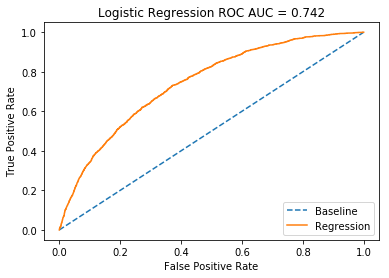

In [203]:
model = LogisticRegression(C=1.0,penalty='l1')
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()